In [1]:
from google.colab import drive
drive.mount('/content/drive/')
# drive.mount('/content/drive/MyDrive/CSE291/assignments/assignment3/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [1]:
# !cp drive/MyDrive/CSE291/assignments/assignment3/code/dataset.py dataset.py
# !cp drive/MyDrive/CSE291/assignments/assignment3/code/nerf_utils.py nerf_utils.py
# !cp -r drive/MyDrive/CSE291/assignments/assignment3/data/bottles  data/

# !ls /content/drive/MyDrive/CSE291/assignments/assignment3/

In [1]:
import os
print("Current working directory:", os.getcwd())
import sys
# sys.path.append('/content/drive/MyDrive/CSE291/assignments/assignment3/')
# sys.path.append('/content/drive/MyDrive/CSE291/assignments/assignment3/code/')

import time
import math
import argparse
from PIL import Image
import imageio
import pickle
from tqdm.notebook import tqdm
# from tqdm import tqdm, trange
import importlib

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import torch
import torch.nn as nn
import torch.nn.functional as F

import dataset
import nerf_utils
from nerf_utils import *

Current working directory: /home/sazim/private/CSE291/assignment3/code


In [2]:
importlib.reload(dataset)
importlib.reload(nerf_utils)

<module 'nerf_utils' from '/home/sazim/private/CSE291/assignment3/code/nerf_utils.py'>

In [3]:
# define device type - cuda:0 or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# kwargs = {'num_workers': 4, 'pin_memory': False} if device.type == "cuda" else {}

# Additional Info when using cuda
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Number of GPU devices:", torch.cuda.device_count())
    print("GPU device name:", torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 3), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 3), 'GB')
else:
    print("Device:", device)

np.random.seed(0)

Number of GPU devices: 1
GPU device name: GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Test Positional Encoder

In [4]:
def config_parser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str, default=None, 
                        help='config file path')
    parser.add_argument("--expname", type=str, 
                        help='experiment name')
#     parser.add_argument("--basedir", type=str, default=os.path.join(os.getcwd(), "drive/MyDrive/CSE291/assignments/assignment3/"), 
#                         help='project base directory')
#     parser.add_argument("--logdir", type=str, default=os.path.join(os.getcwd(), "drive/MyDrive/CSE291/assignments/assignment3/logdir/"), 
#                         help='where to store ckpts and logs')
#     parser.add_argument("--datadir", type=str, default=os.path.join(os.getcwd(), "drive/MyDrive/CSE291/assignments/assignment3/data/bottles"), 
#                         help='input data directory')

    parser.add_argument("--basedir", type=str, default=os.path.join(os.getcwd(), "../"), 
                        help='project base directory')
    parser.add_argument("--logdir", type=str, default=os.path.join(os.getcwd(), "../logdir/"), 
                        help='where to store ckpts and logs')
    parser.add_argument("--datadir", type=str, default=os.path.join(os.getcwd(), "../data/bottles"), 
                        help='input data directory')

    # training options
    parser.add_argument("--netdepth", type=int, default=8, 
                        help='layers in network')
    parser.add_argument("--netwidth", type=int, default=256, 
                        help='channels per layer')
    parser.add_argument("--netdepth_fine", type=int, default=8, 
                        help='layers in fine network')
    parser.add_argument("--netwidth_fine", type=int, default=256, 
                        help='channels per layer in fine network')

    parser.add_argument("--ray_batch_size", type=int, default=256, 
                        help='batch size (number of random rays per gradient step)')
    parser.add_argument("--chunk", type=int, default=32, 
                        help='number of rays processed in parallel, decrease if running out of memory')
    parser.add_argument("--netchunk", type=int, default=32, 
                        help='number of pts sent through network in parallel, decrease if running out of memory')
    parser.add_argument("--no_batching", action='store_true', 
                        help='only take random rays from 1 image at a time')
    
    parser.add_argument("--lrate", type=float, default=5e-4, 
                        help='learning rate')
    parser.add_argument("--lrate_decay_steps", type=int, default=250, 
                        help='exponential learning rate decay steps (in 1000 steps)')
    parser.add_argument("--decay_rate", type=float, default=0.1, 
                        help='exponential learning rate decay')
    
    parser.add_argument("--no_reload_ckpt", action='store_true', 
                        help='do not reload weights from saved ckpt file (if exists)')
    parser.add_argument("--ckpt_coarsenet_path", type=str, default=None, 
                        help='specific weights npy file to reload for coarse network')

    # rendering options
    parser.add_argument("--num_samples_per_ray", type=int, default=64, 
                        help='number of coarse samples per ray')
    parser.add_argument("--num_fine_samples_per_ray", type=int, default=0,
                        help='number of additional fine samples per ray')
    parser.add_argument("--perturb", type=float, default=1.,
                        help='set to 0. for no jitter, 1. for jitter')
    parser.add_argument("--use_viewdirs", action='store_true', 
                        help='use full 5D input instead of 3D')
    parser.add_argument("--i_embed", type=int, default=0, 
                        help='set 0 for default positional encoding, -1 for none')
    parser.add_argument("--num_freqs_xyz", type=int, default=5, 
                        help='log2 of max freq for positional encoding (3D location)')
    parser.add_argument("--num_freqs_viewdir", type=int, default=2, 
                        help='log2 of max freq for positional encoding (2D direction)')
    parser.add_argument("--raw_noise_std", type=float, default=0., 
                        help='std dev of noise added to regularize sigma_a output, 1e0 recommended')

    parser.add_argument("--render_only", action='store_true', 
                        help='do not optimize, reload weights and render out render_poses path')
    parser.add_argument("--render_test", action='store_true', 
                        help='render the test set instead of render_poses path')
    parser.add_argument("--render_factor", type=int, default=0, 
                        help='downsampling factor to speed up rendering, set 4 or 8 for fast preview')

    # training options
    parser.add_argument("--precrop_iters", type=int, default=0,
                        help='number of steps to train on central crops')
    parser.add_argument("--precrop_frac", type=float,
                        default=.5, help='fraction of img taken for central crops') 

    # dataset options
    parser.add_argument("--dataset_type", type=str, default='llff', 
                        help='options: llff / blender / deepvoxels')
    parser.add_argument("--testskip", type=int, default=8, 
                        help='will load 1/N images from test/val sets, useful for large datasets like deepvoxels')

    ## deepvoxels flags
    parser.add_argument("--shape", type=str, default='greek', 
                        help='options : armchair / cube / greek / vase')

    ## blender flags
    parser.add_argument("--white_bkgd", action='store_true', 
                        help='set to render synthetic data on a white bkgd (always use for dvoxels)')
    parser.add_argument("--half_res", action='store_true', 
                        help='load blender synthetic data at 400x400 instead of 800x800')

    ## llff flags
    parser.add_argument("--factor", type=int, default=1, 
                        help='downsample factor for LLFF images')
    parser.add_argument("--no_ndc", action='store_true', 
                        help='do not use normalized device coordinates (set for non-forward facing scenes)')
    parser.add_argument("--lindisp", action='store_true', 
                        help='sampling linearly in disparity rather than depth')
    parser.add_argument("--spherify", action='store_true', 
                        help='set for spherical 360 scenes')
    parser.add_argument("--llffhold", type=int, default=8, 
                        help='will take every 1/N images as LLFF test set, paper uses 8')

    # logging/saving options
    parser.add_argument("--i_print",   type=int, default=10, 
                        help='frequency of console printout and metric loggin')
    parser.add_argument("--i_img",     type=int, default=500, 
                        help='frequency of tensorboard image logging')
    parser.add_argument("--i_weights", type=int, default=10000, 
                        help='frequency of weight ckpt saving')
    parser.add_argument("--i_testset", type=int, default=50000, 
                        help='frequency of testset saving')
    parser.add_argument("--i_video",   type=int, default=50000, 
                        help='frequency of render_poses video saving')

    return parser


parser = config_parser()
args = parser.parse_args(["--expname=myexp1", "--white_bkgd", "--use_viewdirs"])

In [17]:
print(args.render_test, args.lrate, args.use_viewdirs, args.white_bkgd, args.no_ndc, args.no_batching)
print(args.basedir, args.logdir, args.datadir)

False 0.0005 True True False False
/home/sazim/private/CSE291/assignment3/code/../ /home/sazim/private/CSE291/assignment3/code/../logdir/ /home/sazim/private/CSE291/assignment3/code/../data/bottles


## Training

In [5]:
def train(train_data_dict, test_data_dict, cam_int_mat):
    
    images = train_data_dict['images']
    poses = train_data_dict['poses']
    render_poses = test_data_dict['poses']
    
    print('Loaded dataset', images.shape, poses.shape, render_poses.shape)
    
    print('DEFINING BOUNDS')
    if args.no_ndc:
        near = np.ndarray.min(bds) * .9
        far = np.ndarray.max(bds) * 1.
    else:
        near = 0.
        far = 5.0
    
    print('NEAR, FAR:', near, far)
    
    if args.white_bkgd:
        images = images[...,:3]*images[...,-1:] + (1.-images[...,-1:])
    else:
        images = images[...,:3]

    # Cast intrinsics to right types
    img_height, img_width, focal = images[0].shape[0], images[1].shape[1], cam_int_mat[0,0]
    print(img_height, img_width, focal)

    if cam_int_mat is None:
        cam_int_mat = np.array([
            [focal, 0, 0.5*img_width],
            [0, focal, 0.5*img_height],
            [0, 0, 1]
        ])
    
    # create the log directory and store the hyperparameters in config file
    os.makedirs(os.path.join(args.logdir, args.expname), exist_ok=True)
    args_file = os.path.join(args.logdir, args.expname, "args.txt")
    
    with open(args_file, 'w') as file:
        for arg in sorted(vars(args)):
            attr = getattr(args, arg)
            file.write('{} = {}\n'.format(arg, attr))
            
    if args.config is not None:
        config_file = os.path.join(args.basedir, args.expname, 'config.txt')
        with open(config_file, 'w') as file:
            file.write(open(args.config, 'r').read())

#     print("stage-1")
    # create NeRF model
    render_kwargs_train, render_kwargs_test, start_itr, grad_vars, optimizer = create_NeRF(args)
#     print("stage-2")
    global_step = start_itr
    
    # move test data poses to GPU
    render_poses = torch.tensor(render_poses).to(device)
    
    # prepare ray batch tensor if batching random rays
    use_batching = not args.no_batching
    if use_batching:
        # for random ray batching
        print('get rays')
        rays = np.stack([get_rays_np(img_height, img_width, cam_int_mat, p) for p in poses[:,:3,:4]], 0) # [N, ro+rd, H, W, 3]
        print('done, concats')
        rays_rgb = np.concatenate([rays, images[:,None]], 1) # [N, ro+rd+rgb, H, W, 3]
        rays_rgb = np.transpose(rays_rgb, [0,2,3,1,4]) # [N, H, W, ro+rd+rgb, 3]
#         rays_rgb = np.stack([rays_rgb[i] for i in i_train], 0) # train images only
        rays_rgb = np.reshape(rays_rgb, [-1,3,3]) # [(N-1)*H*W, ro+rd+rgb, 3]
        rays_rgb = rays_rgb.astype(np.float32)
        print('shuffle rays')
        np.random.shuffle(rays_rgb)

        print('done')
        i_batch = 0
        
        # Move training data to GPU
        images = torch.tensor(images).to(device)
        rays_rgb = torch.tensor(rays_rgb).to(device)
    
    poses = torch.tensor(poses).to(device)
        
    num_itr = 12
    print("Start Training !!!")
#     print('TRAIN views are', i_train)
#     print('TEST views are', i_test)
#     print('VAL views are', i_val)
    
    start_itr = start_itr + 1
    for i in tqdm(range(start_itr, num_itr)):
        start_time = time.time()
        
#         print("Stage-9")
        # Sample random ray batch
        if use_batching:
#             print("Stage-10")
            # Random over all images
            batch = rays_rgb[i_batch:i_batch + args.ray_batch_size] # [B, 2+1, 3*?]
            batch = torch.transpose(batch, 0, 1)
            batch_rays, target_s = batch[:2], batch[2]

            i_batch += args.ray_batch_size
            if i_batch >= rays_rgb.shape[0]:
                print("Shuffle data after an epoch!")
                rand_idx = torch.randperm(rays_rgb.shape[0])
                rays_rgb = rays_rgb[rand_idx]
                i_batch = 0
            
#             print("Stage-11")
        else:
#             print("stage-13")
            # Randomly choose one training image and compute rays
            img_i = np.random.choice(range(0,200))
            target = images[img_i]
            target = torch.Tensor(target).to(device)
            pose = poses[img_i, :3,:4]

            if args.ray_batch_size is not None:
#                 print("stage-14")
                rays_o, rays_d = get_rays(img_height, img_width, cam_int_mat, torch.tensor(pose))  # (H, W, 3), (H, W, 3)

                if i < args.precrop_iters:
                    dH = int(img_height//2 * args.precrop_frac)
                    dW = int(img_width//2 * args.precrop_frac)
                    coords = torch.stack(
                        torch.meshgrid(
                            torch.linspace(img_height//2 - dH, img_height//2 + dH - 1, 2*dH), 
                            torch.linspace(img_width//2 - dW, img_width//2 + dW - 1, 2*dW)
                        ), -1)
                    if i == start_itr:
                        print(f"[Config] Center cropping of size {2*dH} x {2*dW} is enabled until iter {args.precrop_iters}")                
                else:
                    coords = torch.stack(torch.meshgrid(torch.linspace(0, img_height-1, img_height), torch.linspace(0, img_width-1, img_width)), -1)  # (H, W, 2)

                coords = torch.reshape(coords, [-1,2])  # (H * W, 2)
                select_inds = np.random.choice(coords.shape[0], size=[args.ray_batch_size], replace=False)  # (ray_batch_size,)
                select_coords = coords[select_inds].long()  # (ray_batch_size, 2)
                rays_o = rays_o[select_coords[:, 0], select_coords[:, 1]]  # (ray_batch_size, 3)
                rays_d = rays_d[select_coords[:, 0], select_coords[:, 1]]  # (ray_batch_size, 3)
                batch_rays = torch.stack([rays_o, rays_d], 0)
                target_s = target[select_coords[:, 0], select_coords[:, 1]]  # (ray_batch_size, 3)
#                 print("stage-15")
        
#         print("Stage-12")
        #####  Core optimization loop  #####
#         rgb, disp, acc, extras = render(img_height, img_width, cam_int_mat, chunk=args.chunk, rays=batch_rays, near=near, 
#                                         far=far, verbose=i < 10, retraw=True, **render_kwargs_train)

        rgb, disp, acc, extras = render(img_height, img_width, cam_int_mat, chunk=args.chunk, rays=batch_rays,
                                        near=near, far=far, ndc=(not args.no_ndc), 
                                        **render_kwargs_train)

        optimizer.zero_grad()
        img_loss = img2mse(rgb, target_s)
#         trans = extras['raw'][...,-1]
        loss = img_loss
        psnr = mse2psnr(img_loss)
        
        if 'rgb0' in extras:
            img_loss0 = img2mse(extras['rgb0'], target_s)
            loss = loss + img_loss0
            psnr0 = mse2psnr(img_loss0)
            
        loss.backward()
        optimizer.step()

        # NOTE: IMPORTANT!
        ###   update learning rate   ###
        decay_steps = args.lrate_decay_steps * 1000
        new_lrate = args.lrate * (args.decay_rate ** (global_step / decay_steps))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lrate
        ################################
        
        dt = time.time() - start_time
        #####           end            #####
        
        if i % args.i_print==0:
#             tqdm.write(f"[TRAIN] Iter: {i} / {num_itr}, Loss: {loss.item()}, PSNR: {psnr.item()}, Time: {dt}")
            print(f"[TRAIN] Iter: {i} / {num_itr}, Loss: {loss.item()}, PSNR: {psnr.item()}, Time: {dt}")
        
        global_step += 1

In [15]:
train(train_data_dict, test_data_dict, cam_int_mat)

Loaded dataset (200, 100, 100, 4) (200, 4, 4) (200, 4, 4)
DEFINING BOUNDS
NEAR, FAR: 0.0 5.0
100 100 109.375
Found checkpoint files: []
get rays
done, concats
shuffle rays
done
Start Training !!!


  8%|▊         | 1/12 [00:01<00:12,  1.15s/it]

[TRAIN] Iter: 0 / 12, Loss: 0.08932062983512878, PSNR: 10.490482330322266, Time: 1.1526141166687012


 92%|█████████▏| 11/12 [00:13<00:01,  1.22s/it]

[TRAIN] Iter: 10 / 12, Loss: 0.09749875962734222, PSNR: 10.11000919342041, Time: 1.2356736660003662


100%|██████████| 12/12 [00:14<00:00,  1.23s/it]


## Load images, pose data, camera intrinsic matrix

In [23]:
resize_factor = 4
train_data_dict, val_data_dict, test_data_dict, cam_int_mat, bbox_mat = dataset.load_data_from_files(store_data=False, 
                                                                                                     resize_factor=resize_factor)

print(train_data_dict['images'].shape, train_data_dict['poses'].shape)
print(val_data_dict['images'].shape, val_data_dict['poses'].shape)
print(test_data_dict['poses'].shape)
print(cam_int_mat.shape, bbox_mat.shape)

print("Number of training images/poses:", train_data_dict['images'].shape[0])
print("Number of test poses:", test_data_dict['poses'].shape[0])

  0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(200, 200, 200, 4) (200, 4, 4)
(0,) (0,)
(200, 4, 4)
(3, 3) (7,)
Number of training images/poses: 200
Number of test poses: 200


In [54]:
for i in range(150):
    img = train_data_dict['images'][i]
#     print(img.shape)
    print(img[:,:,2])

# fig = plt.figure()
# plt.imshow(img)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ...

In [55]:
from torch.utils.tensorboard import SummaryWriter

(800, 800, 4)
[255]
(800, 800, 4)
[0 1]


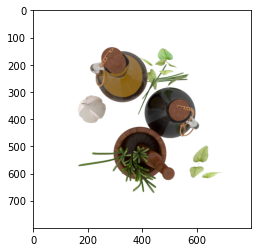

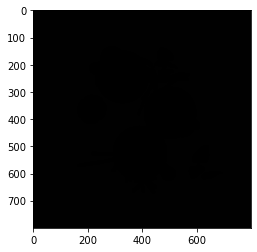

In [48]:
img = imageio.imread("../data/bottles/rgb/0_train_0000.png", ignoregamma=True)
print(img.shape)
print(np.unique(img[:,:,3]))

fig = plt.figure()
plt.imshow(img)

img[..., :3] = np.array(img[..., :3], dtype=np.float32) / 255.0
print(img.shape)

print(np.unique(img[:,:,0]))

fig = plt.figure()
plt.imshow(img)

In [21]:
i, j = np.meshgrid(np.arange(4, dtype=np.float32), np.arange(4, dtype=np.float32), indexing='xy')
print(i)
print(j)

[[0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]]
[[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]


In [11]:
images = train_data_dict['images']
print(images[:,None].shape)

(200, 1, 800, 800, 4)


In [15]:
img = Image.open("../data/bottles/rgb/0_train_0000.png")
print(img.size)
img = img.resize((img.size[0]//8, img.size[1]//8))
print(img.size)
rgb_img = np.array(img) / 255.0
print(rgb_img.shape)

print(np.sum(np.abs(rgb_img[...,0] - rgb_img[...,3])))


# print(rgb_img.shape)
# print(rgb_img.max(), rgb_img.min())
# print(len(np.unique(rgb_img)))

# rgb_img_new = rgb_img[...,:3]*rgb_img[...,-1:] + (1.0 - rgb_img[...,-1:])

# fig = plt.figure()
# plt.imshow(rgb_img)

# fig = plt.figure()
# plt.imshow(rgb_img_new)

# diff = np.sum(rgb_img[...,:3] - rgb_img_new)
# print(diff)

(800, 800)
(100, 100)
(100, 100, 4)
1055.4117647058822


### Load the train and test data dict from stored pickle files

In [ ]:
with open('../data/bottles/pkl_files/train_data_pkl.pickle', 'rb') as handle:
    train_data_dict = pickle.load(handle)

with open('../data/bottles/pkl_files/test_data_pkl.pickle', 'rb') as handle:
    test_data_dict = pickle.load(handle)

In [ ]:
near_dist = 1.0
far_dist = 100.0
t_vals = torch.linspace(0, 1.0, 10)
print(t_vals)

z_vals = near_dist * (1 - t_vals) + far_dist * t_vals
print(z_vals)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
tensor([  1.0000,  12.0000,  23.0000,  34.0000,  45.0000,  56.0000,  67.0000,
         78.0000,  89.0000, 100.0000])


In [ ]:
nerf_out = torch.rand((10,4))
ray_mat = torch.rand((10,6))
ray_dir_mat = torch.rand((10,6))
b = torch.norm(ray_dir_mat[..., None, :], dim=-1)
print(b.shape)

convert_nerfout2rgb(nerf_out, ray_mat, ray_dir_mat)

torch.Size([10, 1])
torch.Size([10, 6])
torch.Size([10, 6])


RuntimeError: The size of tensor a (10) must match the size of tensor b (6) at non-singleton dimension 1

In [ ]:
a = torch.randint(1,9,(2,5))
print(a)

cumprod = torch.cumprod(a, 1)
print(cumprod)

roll = torch.roll(cumprod, 1, -1)
print(roll)

tensor([[5, 7, 2, 4, 1],
        [8, 3, 1, 7, 2]])
tensor([[  5,  35,  70, 280, 280],
        [  8,  24,  24, 168, 336]])
tensor([[280,   5,  35,  70, 280],
        [336,   8,  24,  24, 168]])


In [ ]:
a = torch.randint(0,9,(3,4,6))
print(a)

b = a[..., 0:-1]
print(b)

tensor([[[3, 8, 5, 1, 7, 8],
         [1, 2, 3, 3, 3, 8],
         [0, 4, 1, 7, 8, 2],
         [3, 2, 8, 8, 8, 8]],

        [[7, 4, 4, 6, 7, 2],
         [2, 6, 4, 2, 4, 6],
         [5, 6, 6, 2, 4, 1],
         [3, 6, 4, 2, 5, 7]],

        [[7, 3, 3, 5, 1, 3],
         [1, 6, 7, 2, 5, 5],
         [1, 6, 2, 7, 7, 5],
         [3, 1, 0, 3, 2, 3]]])
tensor([[[3, 8, 5, 1, 7],
         [1, 2, 3, 3, 3],
         [0, 4, 1, 7, 8],
         [3, 2, 8, 8, 8]],

        [[7, 4, 4, 6, 7],
         [2, 6, 4, 2, 4],
         [5, 6, 6, 2, 4],
         [3, 6, 4, 2, 5]],

        [[7, 3, 3, 5, 1],
         [1, 6, 7, 2, 5],
         [1, 6, 2, 7, 7],
         [3, 1, 0, 3, 2]]])


In [59]:
from torch.utils import tensorboard

In [64]:
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


In [67]:
i, j = np.meshgrid(np.arange(4, dtype=np.float32), np.arange(4, dtype=np.float32), indexing='xy')
print(i, "\n", j)

[[0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]
 [0. 1. 2. 3.]] 
 [[0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]]


In [69]:
dirs = np.stack([(i-4)/2., (j-4)/2., np.ones_like(i)], -1)
print(dirs, dirs.shape)

[[[-2.  -2.   1. ]
  [-1.5 -2.   1. ]
  [-1.  -2.   1. ]
  [-0.5 -2.   1. ]]

 [[-2.  -1.5  1. ]
  [-1.5 -1.5  1. ]
  [-1.  -1.5  1. ]
  [-0.5 -1.5  1. ]]

 [[-2.  -1.   1. ]
  [-1.5 -1.   1. ]
  [-1.  -1.   1. ]
  [-0.5 -1.   1. ]]

 [[-2.  -0.5  1. ]
  [-1.5 -0.5  1. ]
  [-1.  -0.5  1. ]
  [-0.5 -0.5  1. ]]] (4, 4, 3)


In [7]:
train_data_dict['poses'][0]

array([[-1.0e+00, -8.7e-08, -0.0e+00, -0.0e+00],
       [-8.7e-08,  1.0e+00,  0.0e+00,  0.0e+00],
       [-0.0e+00, -0.0e+00, -1.0e+00,  3.0e+00],
       [ 0.0e+00,  0.0e+00,  0.0e+00,  1.0e+00]])

In [18]:
rays_o, rays_d = get_rays_np(100, 100, cam_int_mat, train_data_dict['poses'][5])
print(rays_o.shape, rays_d.shape)

rays_o[49, 49], rays_d[49, 49]

(100, 100, 3) (100, 100, 3)


(array([0.79038756, 0.50277986, 2.84999999]),
 array([-0.26588397, -0.17996935, -0.94714515]))

In [11]:
y = np.random.rand(3,3)
print(y)

z = 3 * (y - 0.5)
print(z)

print((255.0 * np.clip(z, 0, 1.0)).astype(np.uint8))

[[0.63992102 0.14335329 0.94466892]
 [0.52184832 0.41466194 0.26455561]
 [0.77423369 0.45615033 0.56843395]]
[[ 0.41976306 -1.06994014  1.33400675]
 [ 0.06554497 -0.25601418 -0.70633316]
 [ 0.82270107 -0.131549    0.20530185]]
[[107   0 255]
 [ 16   0   0]
 [209   0  52]]


In [9]:
test_reqd_poses = np.array([test_data_dict['poses'][0], test_data_dict['poses'][16], test_data_dict['poses'][55],
                   test_data_dict['poses'][93], test_data_dict['poses'][160]])

print(test_reqd_poses.shape)

(5, 4, 4)


In [10]:
base_dir = os.path.join(os.getcwd(), "../")
data_dir = os.path.join(base_dir, "data/bottles/")
rgb_dir = os.path.join(data_dir, "rgb")
pose_dir = os.path.join(data_dir, "pose")

pose_mat = np.array([np.loadtxt(os.path.join(pose_dir, '2_test_0000.txt')),
            np.loadtxt(os.path.join(pose_dir, '2_test_0016.txt')),
            np.loadtxt(os.path.join(pose_dir, '2_test_0055.txt')),
            np.loadtxt(os.path.join(pose_dir, '2_test_0093.txt')),
            np.loadtxt(os.path.join(pose_dir, '2_test_0160.txt'))])

print(pose_mat.shape)

(5, 4, 4)


In [11]:
np.sum(np.abs(test_reqd_poses - pose_mat))

0.0

In [14]:
test_reqd_poses[3], pose_mat[3]

(array([[ 8.03520109e-01,  3.97158867e-01, -4.43418798e-01,
          1.33025610e+00],
        [ 5.95277569e-01, -5.36094709e-01,  5.98537402e-01,
         -1.79561213e+00],
        [-1.20000000e-08, -7.44894132e-01, -6.67182665e-01,
          2.00154826e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([[ 8.03520109e-01,  3.97158867e-01, -4.43418798e-01,
          1.33025610e+00],
        [ 5.95277569e-01, -5.36094709e-01,  5.98537402e-01,
         -1.79561213e+00],
        [-1.20000000e-08, -7.44894132e-01, -6.67182665e-01,
          2.00154826e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]))

In [44]:
train_images = train_data_dict['images']
print(train_images.shape)
print(train_images[:,None].shape)

(200, 200, 200, 4)
(200, 1, 200, 200, 4)


In [26]:
train_images_1 = train_images[...,:3]*train_images[...,-1:] + (1.0 - train_images[...,-1:])
train_images_2 = train_images[...,:3]

train_images_1 - train_images_2

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

In [57]:
list(range(0, 1024, 1024*4))

[0]